<a href="https://colab.research.google.com/github/akamojo/QRS-Detector/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial from: https://blog.orikami.nl/diagnosing-myocardial-infarction-using-long-short-term-memory-networks-lstms-cedf5770a257?fbclid=IwAR36opHio7v89bnXYFGu6vB0k23_v6NiFx_dG50V32ZVWCTaIUDvJHNDBiA

In [0]:
!pip install wfdb

In [0]:
from wfdb import io, plot
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import CuDNNLSTM
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [0]:
from wfdb import io, plot

# The folder where you want to store your data
data_folder = 'data'
# First get the list of available records and then download 
# those records and store them in data_folder.
record_names = io.get_record_list('ptbdb')
io.dl_database('ptbdb', data_folder, record_names)

# Read the first record
record_name = record_names[0]
record = io.rdrecord(record_name=os.path.join('data', record_name)) 

Finished downloading files


In [0]:
record.p_signal.shape

(38400, 15)

In [0]:
record.sig_name # which ones are we supposed to take?

['i',
 'ii',
 'iii',
 'avr',
 'avl',
 'avf',
 'v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'vx',
 'vy',
 'vz']

In [0]:
record.comments

['age: 81',
 'sex: female',
 'ECG date: 01/10/1990',
 'Diagnose:',
 'Reason for admission: Myocardial infarction',
 'Acute infarction (localization): infero-latera',
 'Former infarction (localization): no',
 'Additional diagnoses: Diabetes mellitus',
 'Smoker: no',
 'Number of coronary vessels involved: 1',
 'Infarction date (acute): 29-Sep-90',
 'Previous infarction (1) date: n/a',
 'Previous infarction (2) date: n/a',
 'Hemodynamics:',
 'Catheterization date: 16-Oct-90',
 'Ventriculography: Akinesia inferior wall',
 'Chest X-ray: Heart size upper limit of norm',
 'Peripheral blood Pressure (syst/diast):  140/80 mmHg',
 'Pulmonary artery pressure (at rest) (syst/diast): n/a',
 'Pulmonary artery pressure (at rest) (mean): n/a',
 'Pulmonary capillary wedge pressure (at rest): n/a',
 'Cardiac output (at rest): n/a',
 'Cardiac index (at rest): n/a',
 'Stroke volume index (at rest): n/a',
 'Pulmonary artery pressure (laod) (syst/diast): n/a',
 'Pulmonary artery pressure (laod) (mean): n/a'

In [0]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip

     | 645kB 3.5MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-2rh_iejg/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
from tqdm import tqdm_notebook as tqdm

records = []
for record_name in tqdm(record_names):
    record = io.rdrecord(record_name=os.path.join('data', record_name))
    #label = comments_to_dict(record.comments)['Reason for admission'][1:]
    label = record.comments[4].split(": ")[-1]
    patient = record_name.split('/')[0]
    signal_length = record.sig_len
    records.append({'name':record_name, 'label':label, 'patient':patient, 'signal_length':signal_length})
    
channels = record.sig_name
df_records = pd.DataFrame(records) 

/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm_notebook.py:88: TqdmExperimentalWarning: Detect Google Colab 0.0.1a2 and thus load dummy ipywidgets package. Note that UI is different from that in Jupyter. See https://github.com/tqdm/tqdm/pull/640
  " See https://github.com/tqdm/tqdm/pull/640".format(colab.__version__), TqdmExperimentalWarning)


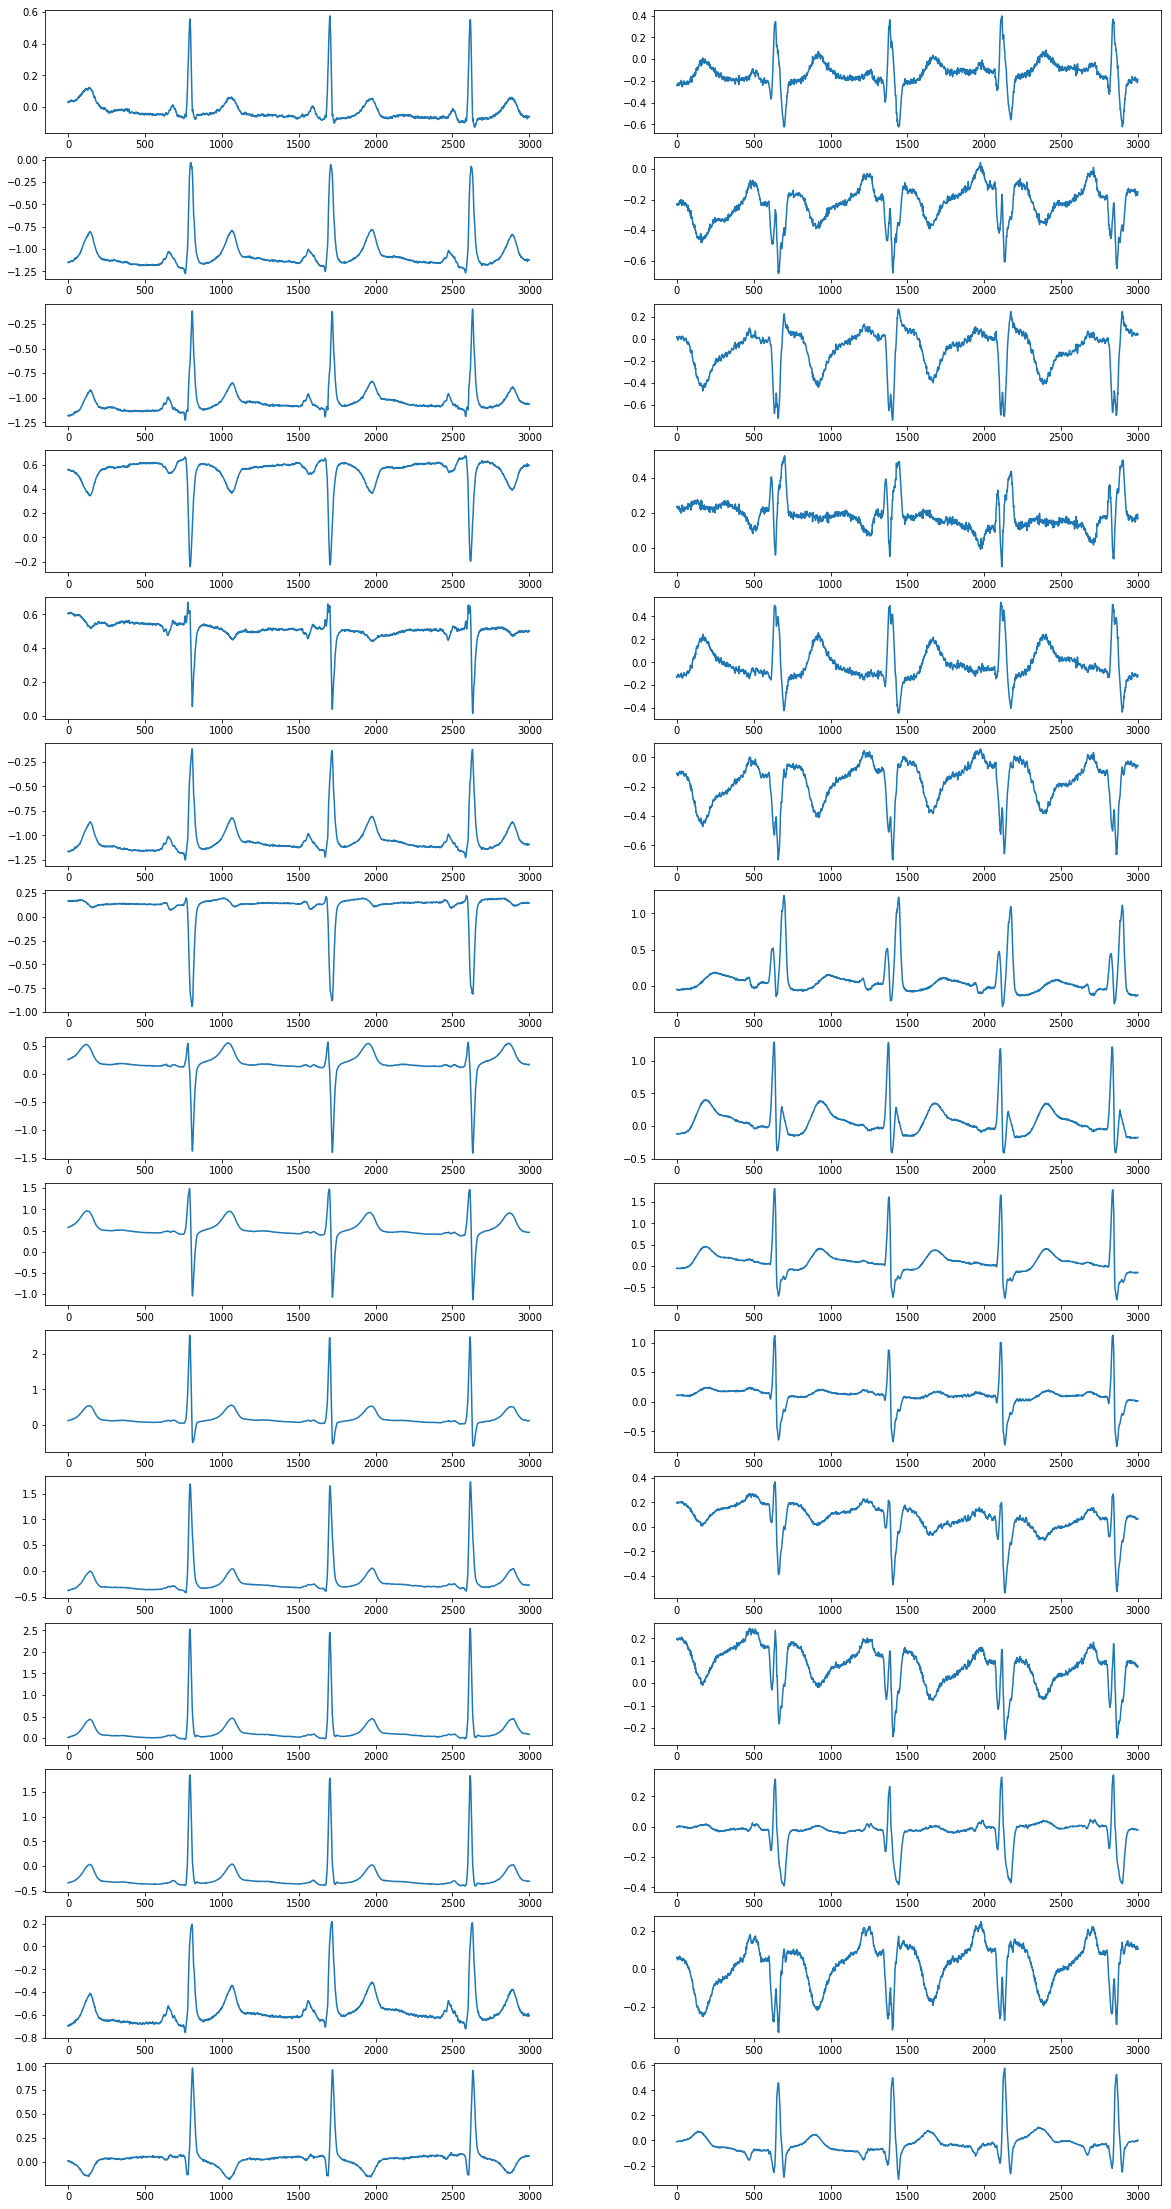

In [0]:
# Get the first occurence of healthy control and Myocardial infarction
control = df_records[df_records['label'] == 'Healthy control'].iloc[0]
infarct = df_records[df_records['label'] == 'Myocardial infarction'].iloc[0]
# Get the signal data
control_data = io.rdrecord(record_name=os.path.join('data', control['name'])).p_signal
infarct_data = io.rdrecord(record_name=os.path.join('data', infarct['name'])).p_signal

# Transpose the data for easier handling.
control_data = np.transpose(control_data)
infarct_data = np.transpose(infarct_data)

# Plot data 
fig, axes = plt.subplots(15, 2, figsize=(20, 40))
for idx, (control_channel, infarct_channel) in enumerate(zip(control_data, infarct_data)):
    axes[idx][0].plot(control_channel[:3000])
    axes[idx][1].plot(infarct_channel[:3000])

In [0]:
import numpy as np

np.random.seed(1337)

# These are the labels we'll be using. I you want to include more heart conditions, simply add them to this list.
selected_labels = [
    'Healthy control',
    'Myocardial infarction'
    ]
# The label map will be used to do one-hot encoding with the labels.
label_map = {label: value for label, value in zip(selected_labels, range(len(selected_labels)))}

test_patients = []
train_patients = []
# We will use 80% of the available subject to train the model
# The remaining 20% will be used to test the performance.
test_size = 0.2

# Randomly divide the subjects in train and test set. 
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])

def make_set(df_data, label_map, record_id, window_size=2048, n_channels = 15):
    """
    1. Loads the ECG data from the records specified in df_data
    2. Divide the signal data in windows of size window_size (default of 2048 which is enough to capture 3 heart beats.)
    
    
    returns:
        dataX: contains windowed ecg data (shape = n_windwows, n_channels, window_size)
        dataY: containts label for each window
        record_list: If required also returns a list specifying the record name for each window, else is empty list.
    """
    n_windows = 0
    
    for _, record in df_data.iterrows():
        n_windows+= record['signal_length']//window_size

    dataX = np.zeros((n_windows, n_channels, window_size))
    dataY = np.zeros((n_windows, len(label_map)))
    
    record_list = []
    
    nth_window = 0
    for i, (patient, record) in enumerate(df_data.iterrows()):
        # read the record, get the signal data and transpose it
        signal_data = io.rdrecord(os.path.join('data', record['name'])).p_signal.transpose()
        n_rows = signal_data.shape[-1]
        n_windows = n_rows//window_size
        dataX[nth_window:nth_window+n_windows] = np.array([signal_data[:,i*window_size:(i+1)*window_size] for i in range(n_windows)])
        dataY[nth_window:nth_window+n_windows][:, label_map[record.label]] = 1
        nth_window+=n_windows
        
        if record_id:
            record_list+= n_windows*[record['name']]
        
    return dataX, dataY, record_list
  
# Set patient as the index of the dataframe to easily extract the meta data by patient
df_patient_records = df_records.set_index('patient')
# Select the meta data of the patient we need.
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[test_patients]
window_size = 2048
trainX, trainY, _ = make_set(df_train_patients, label_map, False, window_size, 15)
testX, testY, record_list = make_set(df_test_patients,label_map, True, window_size, 15)

In [0]:
def make_model(input_shape, output_dim, dropout=0.01):
    print("model dim: ", input_shape, output_dim)
    model = Sequential()
    model.add(CuDNNLSTM(256, input_shape=input_shape, batch_size=None, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(CuDNNLSTM(128, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(CuDNNLSTM(64))
    model.add(Dropout(dropout))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

In [0]:
# Shuffle the data
trainX, trainY = shuffle(trainX, trainY)

# Since we have a large class inbalance we need to udjust the weights for it.
fractions = 1-trainY.sum(axis=0)/len(trainY)
weights = fractions[trainY.argmax(axis=1)]

model = make_model((trainX.shape[1], trainX.shape[2]), trainY.shape[-1])

model.fit(trainX, trainY, epochs=50, batch_size=64, sample_weight=weights)

model dim:  (15, 2048) 2
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
19910/19910 [==============================] - 17s 833us/step - loss: 0.1616
Epoch 2/50
19910/19910 [==============================] - 8s 420us/step - loss: 0.1168
Epoch 3/50
19910/19910 [==============================] - 8s 417us/step - loss: 0.0918
Epoch 4/50
19910/19910 [==============================] - 8s 418us/step - loss: 0.0727
Epoch 5/50
19910/19910 [==============================] - 8s 416us/step - loss: 0.0649
Epoch 6/50
19910/19910 [==============================] - 8s 420us/step - loss: 0.0473
Epoch 7/50
19910/19910 [==============================] - 8s 417us/step - loss: 0.0386
Epoch 8/50
19910/19910 [==============================] - 9s 439us/step - loss: 0.0308
Epoch 9/50
19910/19910 [===================

In [0]:
# Predict the label for each sequence
output = model.predict_classes(testX)
# Inspect the accuracy on sequence level.
print(confusion_matrix(testY.argmax(axis=1), output))

# Group all sequences of the same subject and take the average of all the predictions
# Remember labels are one-hot encoded, so [1,0] is healthy, [0,1] is infarct. 
# If we take the argmax over the output we get a 0 (healthy) or 1 (infarct) as label.
summed = pd.DataFrame({'record':record_list, 'predictions':output, 'label':testY.argmax(axis=1)}).groupby('record').mean()
summed["predicted label"]= summed['predictions'] > 0.5

print(classification_report(summed['label'], summed["predicted label"]))

[[ 616  281]
 [ 587 3165]]
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67        16
         1.0       0.94      0.88      0.91        67

    accuracy                           0.86        83
   macro avg       0.77      0.82      0.79        83
weighted avg       0.87      0.86      0.86        83

